In [1]:
import numpy as np
import tensorflow as tf
from tcn import TCN
import os

os.chdir("../src/")
from models import tcn
from utils import auxiliary_plots, metrics
from preprocessing import normalization, data_generation

SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)

os.chdir("../notebooks/")

In [2]:
TRAIN_FILE_NAME = '../data/hourly_20140102_20191101_train.csv'
TEST_FILE_NAME = '../data/hourly_20140102_20191101_test.csv'

FORECAST_HORIZON = 24
PAST_HISTORY = 192
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EPOCHS = 25
METRICS = ['mape']

TCN_PARAMS = {
    'nb_filters': 128,
    'kernel_size': 3,
    'nb_stacks': 1,
    'dilations': [1, 2, 4, 8, 16, 32, 64],
    'dropout_rate': 0,
}


## Read data  

In [3]:
# Read train file
with open(TRAIN_FILE_NAME, 'r') as datafile:
    ts_train = datafile.readlines()[1:]  # skip the header
    ts_train = np.asarray([np.asarray(l.rstrip().split(',')[0], dtype=np.float32) for l in ts_train])
    ts_train = np.reshape(ts_train, (ts_train.shape[0],))

# Read test data file
with open(TEST_FILE_NAME, 'r') as datafile:
    ts_test = datafile.readlines()[1:]  # skip the header
    ts_test = np.asarray([np.asarray(l.rstrip().split(',')[0], dtype=np.float32) for l in ts_test])
    ts_test = np.reshape(ts_test, (ts_test.shape[0],))
    
# Train/validation split
TRAIN_SPLIT = int(ts_train.shape[0] * 0.8)

# Normalize training data
norm_params = normalization.get_normalization_params(ts_train[:TRAIN_SPLIT])
ts_train = normalization.normalize(ts_train, norm_params)
# Normalize test data with train params
ts_test = normalization.normalize(ts_test, norm_params)

# Get x and y for training and validation
x_train, y_train = data_generation.univariate_data(ts_train, 0, TRAIN_SPLIT, PAST_HISTORY, FORECAST_HORIZON)
x_val, y_val = data_generation.univariate_data(ts_train, TRAIN_SPLIT - PAST_HISTORY, ts_train.shape[0],
                                                   PAST_HISTORY, FORECAST_HORIZON)

# Get x and y for test data
x_test, y_test = data_generation.univariate_data(ts_test, 0, ts_test.shape[0], PAST_HISTORY, FORECAST_HORIZON)

# Convert numpy data to tensorflow dataset
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).repeat()
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## TCN: Create and train model

In [4]:
model = tcn(x_train.shape, FORECAST_HORIZON, 'adam', 'mae', 
            nb_filters=TCN_PARAMS['nb_filters'],
            kernel_size=TCN_PARAMS['kernel_size'],
            nb_stacks= TCN_PARAMS['nb_stacks'],
            dilations=TCN_PARAMS['dilations'],
            dropout_rate=TCN_PARAMS['dropout_rate'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 1)]          0         
_________________________________________________________________
tcn (TCN)                    (None, 128)               789248    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
Total params: 792,944
Trainable params: 792,944
Non-trainable params: 0
_________________________________________________________________


Train for 766 steps, validate for 766 steps
Epoch 1/25
765/766 [============================>.] - ETA: 0s - loss: 0.4140
Epoch 00001: saving model to training_tcn/cp.ckpt
766/766 [==============================] - 162s 211ms/step - loss: 0.4136 - val_loss: 0.1328
Epoch 2/25
765/766 [============================>.] - ETA: 0s - loss: 0.1107
Epoch 00002: saving model to training_tcn/cp.ckpt
766/766 [==============================] - 160s 209ms/step - loss: 0.1106 - val_loss: 0.1033
Epoch 3/25
765/766 [============================>.] - ETA: 0s - loss: 0.0935
Epoch 00003: saving model to training_tcn/cp.ckpt
766/766 [==============================] - 157s 205ms/step - loss: 0.0934 - val_loss: 0.0913
Epoch 4/25
765/766 [============================>.] - ETA: 0s - loss: 0.0844
Epoch 00004: saving model to training_tcn/cp.ckpt
766/766 [==============================] - 160s 209ms/step - loss: 0.0844 - val_loss: 0.0860
Epoch 5/25
765/766 [============================>.] - ETA: 0s - loss: 0.0774

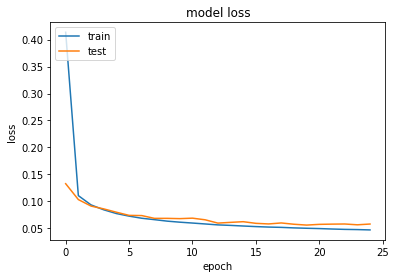

In [5]:
TRAIN_MODEL = True   

checkpoint_path = "training_tcn/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

if TRAIN_MODEL:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
    evaluation_interval = int(np.ceil(x_train.shape[0] / BATCH_SIZE))
    history = model.fit(train_data, 
                        epochs=EPOCHS,
                        steps_per_epoch=evaluation_interval,
                        validation_data=val_data, validation_steps=evaluation_interval,
                        callbacks=[cp_callback])
    auxiliary_plots.plot_training_history(history, ['loss'])

model.load_weights(checkpoint_path)

## Validation results

In [6]:
val_forecast = model.predict(x_val)
val_forecast = normalization.denormalize(val_forecast, norm_params)
y_val_denormalized = normalization.denormalize(y_val, norm_params)
val_metrics = metrics.evaluate(y_val_denormalized, val_forecast, METRICS)
print('Validation scores', val_metrics)

Validation scores {'mape': 0.009155464}


## Test results

In [7]:
test_forecast = model.predict(test_data)
test_forecast = normalization.denormalize(test_forecast, norm_params)
y_test_denormalized = normalization.denormalize(y_test, norm_params)
x_test_denormalized = normalization.denormalize(x_test, norm_params)
test_metrics = metrics.evaluate(y_test_denormalized, test_forecast, METRICS)
print('Test scores', test_metrics)

Test scores {'mape': 0.009535441}
